## Google stock data

The data set is avaliable at: https://finance.yahoo.com/quote/GOOG/history

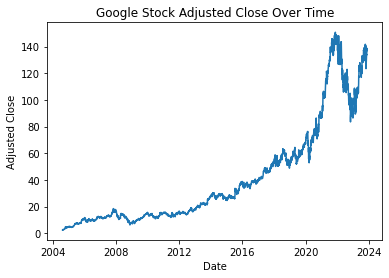

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reading the data from CSV file
GoogleStock = pd.read_csv("GOOG.csv")

# Selecting the Adjusted Close column
GoogleStock_AdjClose = GoogleStock['Adj Close']

# Converting the column to a time series
GoogleStock_AdjClose_ts = pd.Series(GoogleStock_AdjClose.values, index=pd.to_datetime(GoogleStock['Date']))

# Plotting the time series
plt.plot(GoogleStock_AdjClose_ts)
plt.title('Google Stock Adjusted Close Over Time')
plt.xlabel('Date')
plt.ylabel('Adjusted Close')
plt.show()

The plot shows the time series is non-stationary. So the data is tranformed to a stationary series

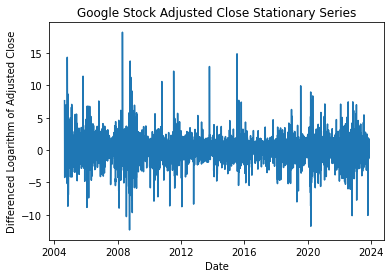

In [2]:
# Calculating the logarithm of the Adjusted Close prices
log_GoogleStock_AdjClose = np.log(GoogleStock_AdjClose_ts)

# Compute the difference to obtain a stationary series
GoogleStock_AdjClose_stationary = log_GoogleStock_AdjClose.diff() * 100

# Drop NaN values that result from differencing
GoogleStock_AdjClose_stationary = GoogleStock_AdjClose_stationary.dropna()

# Plotting the stationary series
plt.plot(GoogleStock_AdjClose_stationary)
plt.title('Google Stock Adjusted Close Stationary Series')
plt.xlabel('Date')
plt.ylabel('Differenced Logarithm of Adjusted Close')
plt.show()

Acf and Pacf are obtained to check the stationarity of the data.

C:\Users\ACER\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


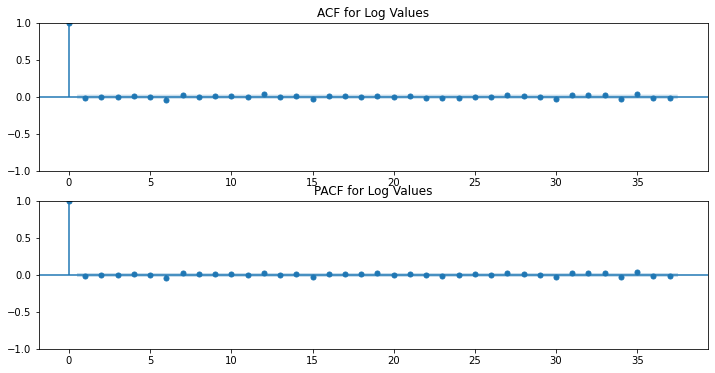

In [3]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Plot acf
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(GoogleStock_AdjClose_stationary, ax=plt.gca(), title='ACF for Log Values')
# Plot pacf
plt.subplot(212)
plot_pacf(GoogleStock_AdjClose_stationary, ax=plt.gca(), title='PACF for Log Values')
plt.show()

QQ plot is obtained to check the distribution of the data.

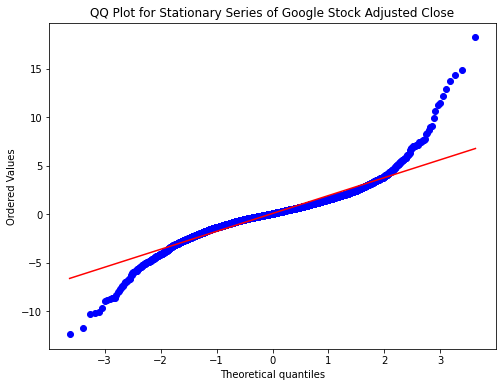

In [4]:
import scipy.stats as stats
# QQ plot for the stationary series
plt.figure(figsize=(8, 6))
stats.probplot(GoogleStock_AdjClose_stationary, dist="norm", plot=plt)
plt.title('QQ Plot for Stationary Series of Google Stock Adjusted Close')
plt.show()

Reshape the data for the future use

In [5]:
# Reshape the data
date = GoogleStock_AdjClose_stationary.index
GoogleStock_AdjClose_stationary = GoogleStock_AdjClose_stationary.values
GoogleStock_AdjClose_stationary = GoogleStock_AdjClose_stationary.reshape(-1, 1)

In [6]:
GoogleStock_AdjClose_stationary

array([[ 7.64330743],
       [ 1.00133139],
       [-4.22893626],
       ...,
       [ 0.69902938],
       [ 1.68681619],
       [-1.27704174]])

Create the traning, validation and testing data

In [7]:
# Define the size for each set
train_size = int(len(GoogleStock_AdjClose_stationary) * 0.7)
validation_size = int(len(GoogleStock_AdjClose_stationary) * 0.2)
test_size = len(GoogleStock_AdjClose_stationary) - train_size - validation_size

# Split the data while maintaining the sequence
train = GoogleStock_AdjClose_stationary[:train_size]
validation = GoogleStock_AdjClose_stationary[train_size:train_size+validation_size]
test = GoogleStock_AdjClose_stationary[train_size+validation_size:]

print(f"Training Set Shape: {train.shape}")
print(f"Validation Set Shape: {validation.shape}")
print(f"Test Set Shape: {test.shape}")

Training Set Shape: (3392, 1)
Validation Set Shape: (969, 1)
Test Set Shape: (485, 1)


Create sequence of data for RNNs architecures.

In [8]:
# Updated Data Preparation Function
def create_sequences(data, time_steps=1):
    Xs, ys = [], []
    for i in range(len(data) - time_steps):
        Xs.append(data[i:(i + time_steps)])
        ys.append(data[i + time_steps])
    return np.array(Xs), np.array(ys)

# Define the time steps for each sequence
time_steps = 60

# Prepare the sequences
X_train, y_train = create_sequences(train, time_steps)
X_val, y_val = create_sequences(validation, time_steps)
X_test, y_test = create_sequences(test, time_steps)


Create the function to build each architecure.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout, Input, GRU
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import datetime
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.layers import BatchNormalization 
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K

# Updated SimpleRNN Model Function
def build_simple_rnn(input_shape, units=50, dropout_rate=0.2, learning_rate=0.001, regularization=l2(0.01)):
    model = Sequential([
        SimpleRNN(units, input_shape=input_shape, kernel_regularizer=regularization),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Updated LSTM Model Function
def build_lstm(input_shape, units=50, dropout_rate=0.2, learning_rate=0.001, regularization=l2(0.01)):
    model = Sequential([
        SimpleRNN(units, input_shape=input_shape, kernel_regularizer=regularization),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

def build_gru_model(input_shape, units=50, dropout_rate=0.2, learning_rate=0.001, regularization=l2(0.01)):
    inputs = Input(shape=input_shape)
    gru_out = GRU(units, return_sequences=False, dropout=dropout_rate, kernel_regularizer=regularization)(inputs)

    # Output layer
    output = Dense(1)(gru_out)

    model = Model(inputs=[inputs], outputs=output)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    
    return model

Train the model with set of hyperparameters to obtain the best parameter for each model.

In [10]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import TensorBoard
import datetime

# Hyperparameters
units = [50, 100]
dropout_rates = [0.2, 0.3]
learning_rates = [0.001, 0.01]
regularizations = [('l1', l1(0.01)), ('l2', l2(0.01))]

# Function to create a unique log directory 
def create_log_dir(model_type, unit, dropout_rate, lr, regularization_type):
    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    return f"logs/{model_type}/UNIT{unit}_DROPOUT{dropout_rate}_LR{lr}_REG{regularization_type}_{timestamp}"

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Initialize best models and losses
best_models = {'SimpleRNN': None, 'LSTM': None, 'GRU': None}
lowest_val_losses = {'SimpleRNN': float('inf'), 'LSTM': float('inf'), 'GRU': float('inf')}
best_params = {'SimpleRNN': {}, 'LSTM': {}, 'GRU': {}}

# Loop for each model type
for model_type in ['SimpleRNN', 'LSTM', 'GRU']:
    for unit in units:
        for dropout_rate in dropout_rates:
            for lr in learning_rates:
                for reg_name, reg_function in regularizations:
                    # Build model based on type
                    if model_type == 'SimpleRNN':
                        model = build_simple_rnn((60, 1), unit, dropout_rate, lr, reg_function)
                    elif model_type == 'LSTM':
                        model = build_lstm((60, 1), unit, dropout_rate, lr, reg_function)
                    elif model_type == 'GRU':
                        model = build_gru_model((60, 1), unit, dropout_rate, lr, reg_function)

                    # Train and evaluate
                    history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[early_stopping])
                    val_loss = min(history.history['val_loss'])

                    # Update best model and parameters if improvement found
                    if val_loss < lowest_val_losses[model_type]:
                        best_models[model_type] = model
                        lowest_val_losses[model_type] = val_loss
                        best_params[model_type] = {
                            'unit': unit,
                            'dropout_rate': dropout_rate,
                            'learning_rate': lr,
                            'regularization': reg_name
                        }

Epoch 1/20
105/105 [==============================] - 2s 9ms/step - loss: 4.4899 - val_loss: 3.3484
Epoch 2/20
105/105 [==============================] - 1s 7ms/step - loss: 3.9466 - val_loss: 3.3737
Epoch 3/20
105/105 [==============================] - 1s 7ms/step - loss: 3.8653 - val_loss: 3.4037
Epoch 4/20
105/105 [==============================] - 1s 7ms/step - loss: 3.8065 - val_loss: 3.4059
Epoch 5/20
105/105 [==============================] - 1s 7ms/step - loss: 3.7904 - val_loss: 3.4628
Epoch 6/20
105/105 [==============================] - 1s 7ms/step - loss: 3.6489 - val_loss: 3.4396
Epoch 1/20
105/105 [==============================] - 2s 9ms/step - loss: 4.2942 - val_loss: 3.4623
Epoch 2/20
105/105 [==============================] - 1s 7ms/step - loss: 4.0102 - val_loss: 3.5986
Epoch 3/20
105/105 [==============================] - 1s 7ms/step - loss: 3.8841 - val_loss: 3.5115
Epoch 4/20
105/105 [==============================] - 1s 7ms/step - loss: 3.8261 - val_loss: 3.5191


105/105 [==============================] - 1s 7ms/step - loss: 3.4624 - val_loss: 3.3826
Epoch 15/20
105/105 [==============================] - 1s 7ms/step - loss: 3.4642 - val_loss: 3.3800
Epoch 1/20
105/105 [==============================] - 2s 8ms/step - loss: 4.1577 - val_loss: 3.3928
Epoch 2/20
105/105 [==============================] - 1s 6ms/step - loss: 3.5512 - val_loss: 3.3955
Epoch 3/20
105/105 [==============================] - 1s 6ms/step - loss: 3.5679 - val_loss: 3.4056
Epoch 4/20
105/105 [==============================] - 1s 6ms/step - loss: 3.5171 - val_loss: 3.3857
Epoch 5/20
105/105 [==============================] - 1s 6ms/step - loss: 3.5279 - val_loss: 3.3910
Epoch 6/20
105/105 [==============================] - 1s 7ms/step - loss: 3.5159 - val_loss: 3.3826
Epoch 7/20
105/105 [==============================] - 1s 7ms/step - loss: 3.5274 - val_loss: 3.4404
Epoch 8/20
105/105 [==============================] - 1s 6ms/step - loss: 3.5162 - val_loss: 3.3798
Epoch 9/20

105/105 [==============================] - 1s 8ms/step - loss: 4.0546 - val_loss: 3.6145
Epoch 5/20
105/105 [==============================] - 1s 8ms/step - loss: 3.8025 - val_loss: 3.5443
Epoch 6/20
105/105 [==============================] - 1s 8ms/step - loss: 3.8012 - val_loss: 3.5753
Epoch 7/20
105/105 [==============================] - 1s 8ms/step - loss: 3.7418 - val_loss: 3.5558
Epoch 8/20
105/105 [==============================] - 1s 8ms/step - loss: 3.5786 - val_loss: 3.4917
Epoch 9/20
105/105 [==============================] - 1s 8ms/step - loss: 3.6164 - val_loss: 3.5470
Epoch 10/20
105/105 [==============================] - 1s 8ms/step - loss: 3.6028 - val_loss: 3.5047
Epoch 11/20
105/105 [==============================] - 1s 8ms/step - loss: 3.5407 - val_loss: 3.5448
Epoch 12/20
105/105 [==============================] - 1s 8ms/step - loss: 3.5101 - val_loss: 3.6301
Epoch 13/20
105/105 [==============================] - 1s 8ms/step - loss: 3.5279 - val_loss: 3.5708
Epoch 1

105/105 [==============================] - 1s 7ms/step - loss: 3.4798 - val_loss: 3.3837
Epoch 12/20
105/105 [==============================] - 1s 7ms/step - loss: 3.4748 - val_loss: 3.3947
Epoch 13/20
105/105 [==============================] - 1s 7ms/step - loss: 3.4859 - val_loss: 3.4039
Epoch 14/20
105/105 [==============================] - 1s 7ms/step - loss: 3.4702 - val_loss: 3.4104
Epoch 15/20
105/105 [==============================] - 1s 7ms/step - loss: 3.4890 - val_loss: 3.3850
Epoch 16/20
105/105 [==============================] - 1s 7ms/step - loss: 3.4677 - val_loss: 3.3877
Epoch 1/20
105/105 [==============================] - 2s 8ms/step - loss: 3.8787 - val_loss: 3.4042
Epoch 2/20
105/105 [==============================] - 1s 7ms/step - loss: 3.5849 - val_loss: 3.4084
Epoch 3/20
105/105 [==============================] - 1s 7ms/step - loss: 3.5275 - val_loss: 3.4281
Epoch 4/20
105/105 [==============================] - 1s 7ms/step - loss: 3.5650 - val_loss: 3.3757
Epoch 

Epoch 12/20
105/105 [==============================] - 1s 8ms/step - loss: 3.6230 - val_loss: 3.3791
Epoch 13/20
105/105 [==============================] - 1s 9ms/step - loss: 3.6045 - val_loss: 3.4114
Epoch 14/20
105/105 [==============================] - 1s 9ms/step - loss: 3.5515 - val_loss: 3.4161
Epoch 15/20
105/105 [==============================] - 1s 10ms/step - loss: 3.5468 - val_loss: 3.6546
Epoch 16/20
105/105 [==============================] - 1s 9ms/step - loss: 3.5857 - val_loss: 3.4047
Epoch 17/20
105/105 [==============================] - 1s 10ms/step - loss: 3.5735 - val_loss: 3.4673
Epoch 1/20
105/105 [==============================] - 2s 11ms/step - loss: 4.1060 - val_loss: 3.5374
Epoch 2/20
105/105 [==============================] - 1s 9ms/step - loss: 3.7666 - val_loss: 3.5379
Epoch 3/20
105/105 [==============================] - 1s 9ms/step - loss: 3.7058 - val_loss: 3.4925
Epoch 4/20
105/105 [==============================] - 1s 9ms/step - loss: 3.6362 - val_loss

105/105 [==============================] - 1s 8ms/step - loss: 3.6477 - val_loss: 3.4183
Epoch 4/20
105/105 [==============================] - 1s 8ms/step - loss: 3.5699 - val_loss: 3.4533
Epoch 5/20
105/105 [==============================] - 1s 9ms/step - loss: 3.5217 - val_loss: 3.5280
Epoch 6/20
105/105 [==============================] - 1s 9ms/step - loss: 3.5446 - val_loss: 3.4274
Epoch 7/20
105/105 [==============================] - 1s 8ms/step - loss: 3.5125 - val_loss: 3.4940
Epoch 8/20
105/105 [==============================] - 1s 8ms/step - loss: 3.5401 - val_loss: 3.4275
Epoch 1/20
105/105 [==============================] - 3s 18ms/step - loss: 3.6035 - val_loss: 3.4446
Epoch 2/20
105/105 [==============================] - 2s 15ms/step - loss: 3.5428 - val_loss: 3.4551
Epoch 3/20
105/105 [==============================] - 2s 15ms/step - loss: 3.5206 - val_loss: 3.4293
Epoch 4/20
105/105 [==============================] - 2s 15ms/step - loss: 3.5150 - val_loss: 3.4270
Epoch 5

105/105 [==============================] - 2s 14ms/step - loss: 3.4637 - val_loss: 3.3880
Epoch 1/20
105/105 [==============================] - 3s 17ms/step - loss: 3.5399 - val_loss: 3.4562
Epoch 2/20
105/105 [==============================] - 2s 14ms/step - loss: 3.4799 - val_loss: 3.3935
Epoch 3/20
105/105 [==============================] - 1s 14ms/step - loss: 3.4718 - val_loss: 3.3840
Epoch 4/20
105/105 [==============================] - 1s 14ms/step - loss: 3.4690 - val_loss: 3.3834
Epoch 5/20
105/105 [==============================] - 2s 14ms/step - loss: 3.4700 - val_loss: 3.3837
Epoch 6/20
105/105 [==============================] - 2s 14ms/step - loss: 3.4643 - val_loss: 3.3814
Epoch 7/20
105/105 [==============================] - 2s 14ms/step - loss: 3.4629 - val_loss: 3.3829
Epoch 8/20
105/105 [==============================] - 2s 14ms/step - loss: 3.4711 - val_loss: 3.3871
Epoch 9/20
105/105 [==============================] - 1s 14ms/step - loss: 3.4657 - val_loss: 3.3828
E

Epoch 3/20
105/105 [==============================] - 2s 23ms/step - loss: 3.4803 - val_loss: 3.4126
Epoch 4/20
105/105 [==============================] - 3s 28ms/step - loss: 3.4771 - val_loss: 3.3797
Epoch 5/20
105/105 [==============================] - 3s 24ms/step - loss: 3.4713 - val_loss: 3.3520
Epoch 6/20
105/105 [==============================] - 3s 26ms/step - loss: 3.4688 - val_loss: 3.3802
Epoch 7/20
105/105 [==============================] - 3s 25ms/step - loss: 3.4755 - val_loss: 3.3577
Epoch 8/20
105/105 [==============================] - 3s 25ms/step - loss: 3.4759 - val_loss: 3.3695
Epoch 9/20
105/105 [==============================] - 2s 23ms/step - loss: 3.4744 - val_loss: 3.3729
Epoch 10/20
105/105 [==============================] - 2s 24ms/step - loss: 3.4672 - val_loss: 3.3397
Epoch 11/20
105/105 [==============================] - 3s 25ms/step - loss: 3.4590 - val_loss: 3.3506
Epoch 12/20
105/105 [==============================] - 3s 24ms/step - loss: 3.4735 - val_

Save the best model for each architecures.

In [11]:
for model_type in best_models:
    if best_models[model_type] is not None:
        best_models[model_type].save(f'best_{model_type.lower()}_google.keras')

Monitor the losses during the training process of each best model by using Tensorboard.

In [12]:
# Print the best parameters for each model
print("Best SimpleRNN parameters:", best_params['SimpleRNN'])
print("Best LSTM parameters:", best_params['LSTM'])
print("Best GRU parameters:", best_params['GRU'])

# Function to rebuild and retrain the best model with TensorBoard
def retrain_best_model(model_type, best_params):
    best_log_dir = f"logs/Google/{model_type}/best_model"
    best_tensorboard_callback = TensorBoard(log_dir=best_log_dir, histogram_freq=1, write_graph=True, write_images=True)

    # Rebuild the best model with the best hyperparameters
    best_unit = best_params['unit']
    best_dropout_rate = best_params['dropout_rate']
    best_lr = best_params['learning_rate']
    best_reg_function = {'l1': l1(0.01), 'l2': l2(0.01)}[best_params['regularization']]

    if model_type == 'SimpleRNN':
        best_model = build_simple_rnn((60, 1), best_unit, best_dropout_rate, best_lr, best_reg_function)
    elif model_type == 'LSTM':
        best_model = build_lstm((60, 1), best_unit, best_dropout_rate, best_lr, best_reg_function)
    elif model_type == 'GRU':
        best_model = build_gru_model((60, 1), best_unit, best_dropout_rate, best_lr, best_reg_function)

    # Re-train the best model
    best_model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[best_tensorboard_callback, early_stopping])

    # Save the best model
    best_model.save(f'best_{model_type.lower()}_google.keras')

# Retrain and save the best models for SimpleRNN, LSTM, and GRU
for model_type in ['SimpleRNN', 'LSTM', 'GRU']:
    if best_models[model_type] is not None:
        retrain_best_model(model_type, best_params[model_type])

Best SimpleRNN parameters: {'unit': 50, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'regularization': 'l1'}
Best LSTM parameters: {'unit': 100, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'regularization': 'l2'}
Best GRU parameters: {'unit': 100, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'regularization': 'l2'}
Epoch 1/20
105/105 [==============================] - 2s 10ms/step - loss: 4.7190 - val_loss: 3.6506
Epoch 2/20
105/105 [==============================] - 1s 8ms/step - loss: 4.0359 - val_loss: 3.6130
Epoch 3/20
105/105 [==============================] - 1s 8ms/step - loss: 3.8803 - val_loss: 3.6160
Epoch 4/20
105/105 [==============================] - 1s 8ms/step - loss: 3.7848 - val_loss: 3.5387
Epoch 5/20
105/105 [==============================] - 1s 8ms/step - loss: 3.7457 - val_loss: 3.5700
Epoch 6/20
105/105 [==============================] - 1s 8ms/step - loss: 3.7720 - val_loss: 3.5770
Epoch 7/20
105/105 [==============================] - 1s 7ms/step - loss: 3.6712 

Load the Tensorboard.

In [13]:
%load_ext tensorboard
%tensorboard --logdir logs --port 6013

Obtain the predicted values of each model with loss and compare with the actual data.

14/14 [==============================] - 0s 7ms/step - loss: 5.0061


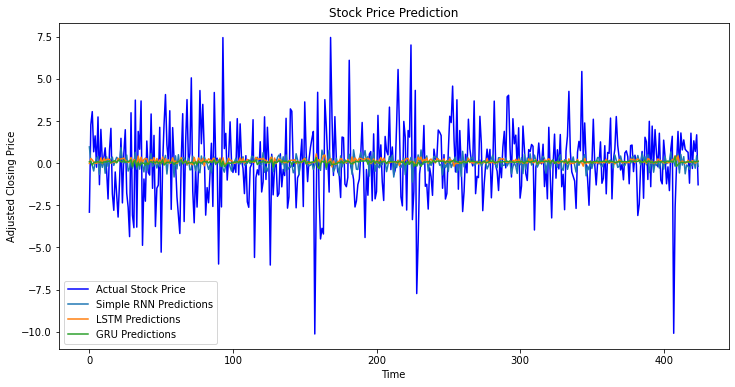

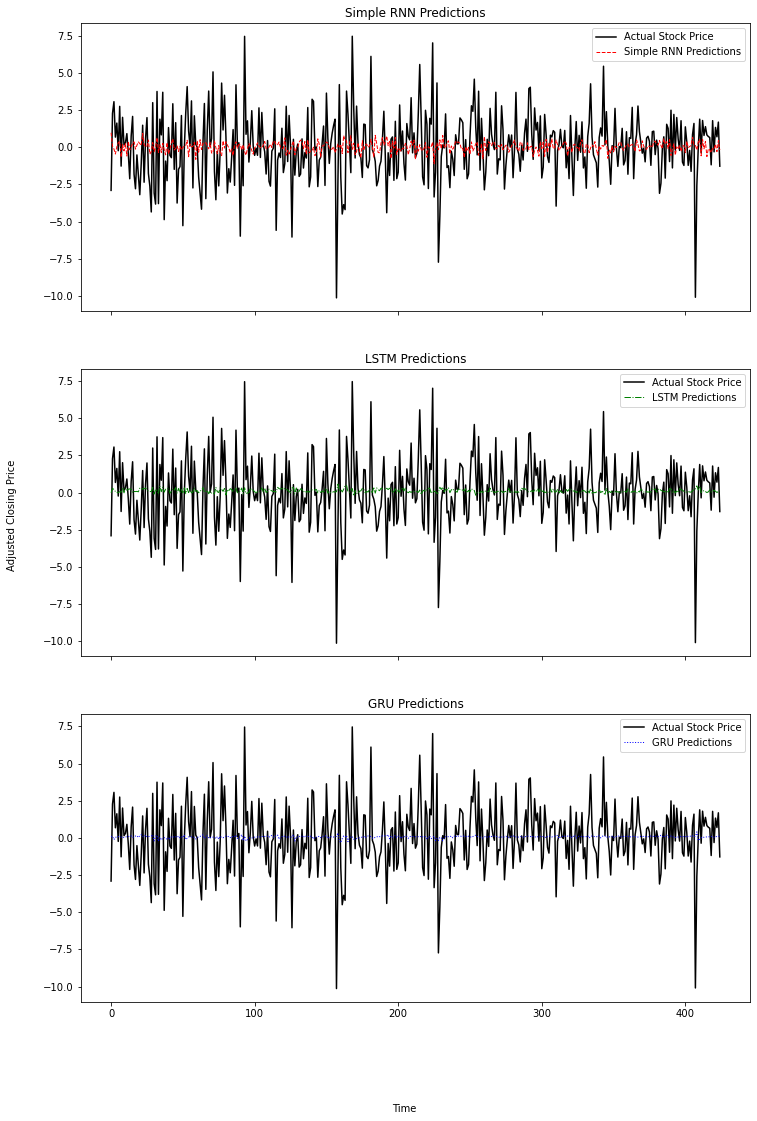

In [14]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load best model
best_simple_rnn = load_model('best_simplernn_google.keras')
best_lstm = load_model('best_lstm_google.keras')
best_gru = load_model('best_gru_google.keras')  

# Predicted values for each model
predicted_simple_rnn = best_simple_rnn.predict(X_test)
predicted_lstm = best_lstm.predict(X_test)
predicted_gru = best_gru.predict(X_test)  

# Test loss for each model
test_loss_simple_rnn = best_simple_rnn.evaluate(X_test, y_test)
test_loss_lstm = best_lstm.evaluate(X_test, y_test)
test_loss_gru = best_gru.evaluate(X_test, y_test)

# Plot compare the predicted values with actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Stock Price', color='blue')  
plt.plot(predicted_simple_rnn, label='Simple RNN Predictions')
plt.plot(predicted_lstm, label='LSTM Predictions')
plt.plot(predicted_gru, label='GRU Predictions')  
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Adjusted Closing Price')
plt.legend()
plt.show()

# Create subplots with shared x-axis
fig, axs = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

# Actual vs Simple RNN
axs[0].plot(y_test, color='black', label='Actual Stock Price')  # Changed line color to blue
axs[0].plot(predicted_simple_rnn, 'r--', label='Simple RNN Predictions', linewidth=1)
axs[0].set_title('Simple RNN Predictions')
axs[0].legend()

# Actual vs LSTM
axs[1].plot(y_test, color='black', label='Actual Stock Price')  # Changed line color to blue
axs[1].plot(predicted_lstm, 'g-.', label='LSTM Predictions', linewidth=1)
axs[1].set_title('LSTM Predictions')
axs[1].legend()

# Actual vs GRU
axs[2].plot(y_test, color='black', label='Actual Stock Price')  # Changed line color to blue
axs[2].plot(predicted_gru, 'b:', label='GRU Predictions', linewidth=1)  # Changed from Attention to GRU
axs[2].set_title('GRU Predictions')
axs[2].legend()

# Set common labels
fig.text(0.5, 0.04, 'Time', ha='center')
fig.text(0.04, 0.5, 'Adjusted Closing Price', va='center', rotation='vertical')

plt.show()

Obtain the correlation between predicted values and actuual values for each best model.

In [18]:
# Calculate the correlation coefficient
print("correlation between RNN predicted values and actual data: ",np.corrcoef(predicted_simple_rnn.flatten(), y_test.flatten())[0, 1])

correlation between RNN predicted values and actual data:  0.009395741065776944


In [19]:
print("correlation between LSTM predicted values and actual data: ",np.corrcoef(predicted_lstm.flatten(), y_test.flatten())[0, 1])

correlation between LSTM predicted values and actual data:  0.021684685532857073


In [20]:
print("correlation between GRU predicted values and actual data: ",np.corrcoef(predicted_gru.flatten(), y_test.flatten())[0, 1])

correlation between GRU predicted values and actual data:  0.010023950612187135


## Commonwealth Bank stock data

The data set is avaliable at: https://au.finance.yahoo.com/quote/CBA.AX/history

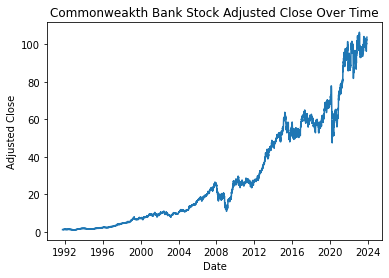

In [36]:
# Reading the data from CSV file
ComStock = pd.read_csv("CBA.AX.csv")

# Selecting the Adjusted Close column
ComStock_AdjClose = ComStock['Adj Close']

# Converting the column to a time series
ComStock_AdjClose_ts = pd.Series(ComStock_AdjClose.values, index=pd.to_datetime(ComStock['Date']))

# Plotting the time series
plt.plot(ComStock_AdjClose_ts)
plt.title('Commonweakth Bank Stock Adjusted Close Over Time')
plt.xlabel('Date')
plt.ylabel('Adjusted Close')
plt.show()

The plot shows the time series is non-stationary. So the data is tranformed to a stationary series

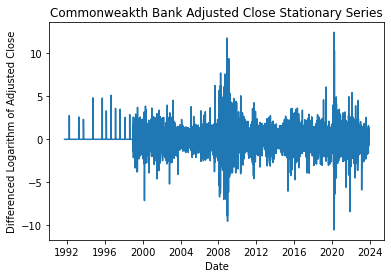

In [37]:
# Calculating the logarithm of the Adjusted Close prices
log_ComStock_AdjClose = np.log(ComStock_AdjClose_ts)

# Compute the difference to obtain a stationary series
ComStock_AdjClose_stationary = log_ComStock_AdjClose.diff() * 100

# Drop NaN values that result from differencing
ComStock_AdjClose_stationary = ComStock_AdjClose_stationary.dropna()

# Plotting the stationary series
plt.plot(ComStock_AdjClose_stationary)
plt.title('Commonweakth Bank Adjusted Close Stationary Series')
plt.xlabel('Date')
plt.ylabel('Differenced Logarithm of Adjusted Close')
plt.show()

The data is filtered to contain tha value after 1999-01-01 since the period before is non stationary.

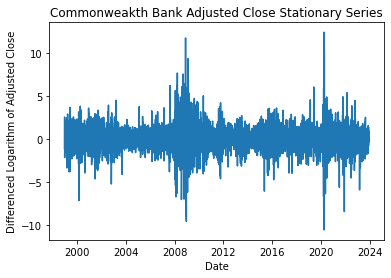

In [38]:
ComStock_AdjClose_stationary = ComStock_AdjClose_stationary[ComStock_AdjClose_stationary.index > '1999-01-01']
plt.plot(ComStock_AdjClose_stationary)
plt.title('Commonweakth Bank Adjusted Close Stationary Series')
plt.xlabel('Date')
plt.ylabel('Differenced Logarithm of Adjusted Close')
plt.show()

Acf and Pacf are obtained to check the stationarity of the data

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


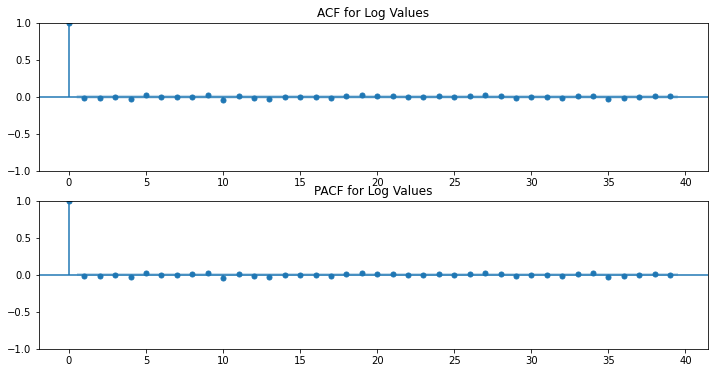

In [39]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(ComStock_AdjClose_stationary, ax=plt.gca(), title='ACF for Log Values')
plt.subplot(212)
plot_pacf(ComStock_AdjClose_stationary, ax=plt.gca(), title='PACF for Log Values')
plt.show()

QQ plot is obtained to check the distribution of the data.

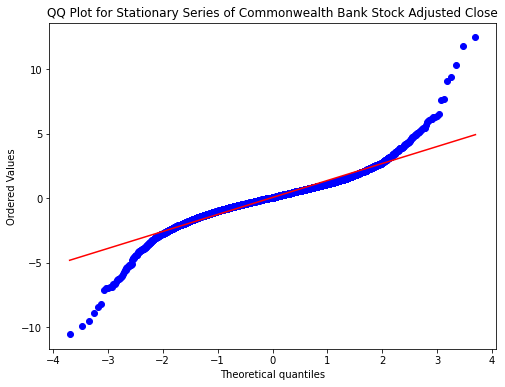

In [40]:
import scipy.stats as stats
# QQ plot for the stationary series
plt.figure(figsize=(8, 6))
stats.probplot(ComStock_AdjClose_stationary, dist="norm", plot=plt)
plt.title('QQ Plot for Stationary Series of Commonwealth Bank Stock Adjusted Close')
plt.show()

Reshape the data for the future use.

In [41]:
ComStock_AdjClose_stationary = ComStock_AdjClose_stationary.values
ComStock_AdjClose_stationary = ComStock_AdjClose_stationary.reshape(-1, 1)

Create the traning, validation and testing data

In [42]:
# Define the size for each set
train_size = int(len(ComStock_AdjClose_stationary) * 0.7)
validation_size = int(len(ComStock_AdjClose_stationary) * 0.2)
test_size = len(ComStock_AdjClose_stationary) - train_size - validation_size

# Split the data while maintaining the sequence
train = ComStock_AdjClose_stationary[:train_size]
validation = ComStock_AdjClose_stationary[train_size:train_size+validation_size]
test = ComStock_AdjClose_stationary[train_size+validation_size:]

print(f"Training Set Shape: {train.shape}")
print(f"Validation Set Shape: {validation.shape}")
print(f"Test Set Shape: {test.shape}")

Training Set Shape: (4437, 1)
Validation Set Shape: (1267, 1)
Test Set Shape: (635, 1)


Create sequence of data for RNNs architecures.

In [43]:
# Updated Data Preparation Function
def create_sequences(data, time_steps=1):
    Xs, ys = [], []
    for i in range(len(data) - time_steps):
        Xs.append(data[i:(i + time_steps)])
        ys.append(data[i + time_steps])
    return np.array(Xs), np.array(ys)

# Define the time steps for each sequence
time_steps = 60

# Prepare the sequences
X_train, y_train = create_sequences(train, time_steps)
X_val, y_val = create_sequences(validation, time_steps)
X_test, y_test = create_sequences(test, time_steps)

Train the model with set of hyperparameters (the same as set applied to the Google data) to obtain the best parameter for each model.

In [46]:
# Initialize best models and losses
best_models = {'SimpleRNN': None, 'LSTM': None, 'GRU': None}
lowest_val_losses = {'SimpleRNN': float('inf'), 'LSTM': float('inf'), 'GRU': float('inf')}
best_params = {'SimpleRNN': {}, 'LSTM': {}, 'GRU': {}}

# Loop for each model type
for model_type in ['SimpleRNN', 'LSTM', 'GRU']:
    for unit in units:
        for dropout_rate in dropout_rates:
            for lr in learning_rates:
                for reg_name, reg_function in regularizations:
                    # Build model based on type
                    if model_type == 'SimpleRNN':
                        model = build_simple_rnn((60, 1), unit, dropout_rate, lr, reg_function)
                    elif model_type == 'LSTM':
                        model = build_lstm((60, 1), unit, dropout_rate, lr, reg_function)
                    elif model_type == 'GRU':
                        model = build_gru_model((60, 1), unit, dropout_rate, lr, reg_function)

                    # Train and evaluate
                    history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[early_stopping])
                    val_loss = min(history.history['val_loss'])

                    # Update best model and parameters if improvement found
                    if val_loss < lowest_val_losses[model_type]:
                        best_models[model_type] = model
                        lowest_val_losses[model_type] = val_loss
                        best_params[model_type] = {
                            'unit': unit,
                            'dropout_rate': dropout_rate,
                            'learning_rate': lr,
                            'regularization': reg_name
                        }

Epoch 1/20
137/137 [==============================] - 2s 9ms/step - loss: 2.9568 - val_loss: 2.3757
Epoch 2/20
137/137 [==============================] - 1s 7ms/step - loss: 2.3166 - val_loss: 2.2972
Epoch 3/20
137/137 [==============================] - 1s 7ms/step - loss: 2.2823 - val_loss: 2.2801
Epoch 4/20
137/137 [==============================] - 1s 7ms/step - loss: 2.2074 - val_loss: 2.2819
Epoch 5/20
137/137 [==============================] - 1s 7ms/step - loss: 2.1559 - val_loss: 2.2620
Epoch 6/20
137/137 [==============================] - 1s 7ms/step - loss: 2.0886 - val_loss: 2.2401
Epoch 7/20
137/137 [==============================] - 1s 7ms/step - loss: 2.0780 - val_loss: 2.2253
Epoch 8/20
137/137 [==============================] - 1s 8ms/step - loss: 2.0455 - val_loss: 2.2195
Epoch 9/20
137/137 [==============================] - 1s 7ms/step - loss: 2.0310 - val_loss: 2.2168
Epoch 10/20
137/137 [==============================] - 1s 8ms/step - loss: 2.0013 - val_loss: 2.2055

137/137 [==============================] - 1s 7ms/step - loss: 1.9246 - val_loss: 2.1787
Epoch 20/20
137/137 [==============================] - 1s 7ms/step - loss: 1.9048 - val_loss: 2.1757
Epoch 1/20
137/137 [==============================] - 2s 8ms/step - loss: 3.1971 - val_loss: 2.2804
Epoch 2/20
137/137 [==============================] - 1s 7ms/step - loss: 2.6571 - val_loss: 2.3023
Epoch 3/20
137/137 [==============================] - 1s 7ms/step - loss: 2.3912 - val_loss: 2.2572
Epoch 4/20
137/137 [==============================] - 1s 7ms/step - loss: 2.3012 - val_loss: 2.2052
Epoch 5/20
137/137 [==============================] - 1s 7ms/step - loss: 2.1808 - val_loss: 2.1881
Epoch 6/20
137/137 [==============================] - 1s 7ms/step - loss: 2.0973 - val_loss: 2.1999
Epoch 7/20
137/137 [==============================] - 1s 7ms/step - loss: 2.0606 - val_loss: 2.1919
Epoch 8/20
137/137 [==============================] - 1s 7ms/step - loss: 2.0024 - val_loss: 2.1707
Epoch 9/20

137/137 [==============================] - 1s 9ms/step - loss: 2.2528 - val_loss: 2.1211
Epoch 4/20
137/137 [==============================] - 1s 8ms/step - loss: 2.1540 - val_loss: 2.1162
Epoch 5/20
137/137 [==============================] - 1s 9ms/step - loss: 2.0971 - val_loss: 2.1224
Epoch 6/20
137/137 [==============================] - 1s 11ms/step - loss: 2.0342 - val_loss: 2.1274
Epoch 7/20
137/137 [==============================] - 1s 9ms/step - loss: 2.0232 - val_loss: 2.1182
Epoch 8/20
137/137 [==============================] - 1s 8ms/step - loss: 2.0161 - val_loss: 2.1195
Epoch 9/20
137/137 [==============================] - 1s 9ms/step - loss: 1.9770 - val_loss: 2.1178
Epoch 1/20
137/137 [==============================] - 2s 10ms/step - loss: 2.4068 - val_loss: 2.2359
Epoch 2/20
137/137 [==============================] - 1s 10ms/step - loss: 2.0880 - val_loss: 2.2896
Epoch 3/20
137/137 [==============================] - 1s 9ms/step - loss: 2.0284 - val_loss: 2.2513
Epoch 4/

137/137 [==============================] - 1s 8ms/step - loss: 1.8849 - val_loss: 2.1104
Epoch 15/20
137/137 [==============================] - 1s 8ms/step - loss: 1.8849 - val_loss: 2.1106
Epoch 16/20
137/137 [==============================] - 1s 8ms/step - loss: 1.8837 - val_loss: 2.1105
Epoch 17/20
137/137 [==============================] - 1s 8ms/step - loss: 1.8848 - val_loss: 2.1105
Epoch 18/20
137/137 [==============================] - 1s 8ms/step - loss: 1.8833 - val_loss: 2.1104
Epoch 19/20
137/137 [==============================] - 1s 8ms/step - loss: 1.8840 - val_loss: 2.1104
Epoch 20/20
137/137 [==============================] - 1s 9ms/step - loss: 1.8839 - val_loss: 2.1115
Epoch 1/20
137/137 [==============================] - 2s 8ms/step - loss: 2.7429 - val_loss: 2.2719
Epoch 2/20
137/137 [==============================] - 1s 7ms/step - loss: 2.3337 - val_loss: 2.2478
Epoch 3/20
137/137 [==============================] - 1s 7ms/step - loss: 2.2920 - val_loss: 2.3228
Epoch

137/137 [==============================] - 1s 7ms/step - loss: 2.0432 - val_loss: 2.1448
Epoch 1/20
137/137 [==============================] - 2s 8ms/step - loss: 2.3170 - val_loss: 2.2304
Epoch 2/20
137/137 [==============================] - 1s 7ms/step - loss: 2.0313 - val_loss: 2.2374
Epoch 3/20
137/137 [==============================] - 1s 7ms/step - loss: 1.9876 - val_loss: 2.1803
Epoch 4/20
137/137 [==============================] - 1s 7ms/step - loss: 1.9645 - val_loss: 2.1831
Epoch 5/20
137/137 [==============================] - 1s 7ms/step - loss: 1.9741 - val_loss: 2.1354
Epoch 6/20
137/137 [==============================] - 1s 7ms/step - loss: 1.9144 - val_loss: 2.1270
Epoch 7/20
137/137 [==============================] - 1s 7ms/step - loss: 1.8938 - val_loss: 2.1179
Epoch 8/20
137/137 [==============================] - 1s 7ms/step - loss: 1.8908 - val_loss: 2.1136
Epoch 9/20
137/137 [==============================] - 1s 7ms/step - loss: 1.8857 - val_loss: 2.1115
Epoch 10/20

137/137 [==============================] - 1s 9ms/step - loss: 1.9495 - val_loss: 2.1411
Epoch 6/20
137/137 [==============================] - 1s 8ms/step - loss: 1.9223 - val_loss: 2.1152
Epoch 7/20
137/137 [==============================] - 1s 8ms/step - loss: 1.9269 - val_loss: 2.1783
Epoch 8/20
137/137 [==============================] - 1s 8ms/step - loss: 1.8974 - val_loss: 2.1239
Epoch 9/20
137/137 [==============================] - 1s 8ms/step - loss: 1.8881 - val_loss: 2.1110
Epoch 10/20
137/137 [==============================] - 1s 8ms/step - loss: 1.8861 - val_loss: 2.1107
Epoch 11/20
137/137 [==============================] - 1s 8ms/step - loss: 1.8841 - val_loss: 2.1105
Epoch 12/20
137/137 [==============================] - 1s 9ms/step - loss: 1.8836 - val_loss: 2.1131
Epoch 13/20
137/137 [==============================] - 1s 8ms/step - loss: 1.8836 - val_loss: 2.1105
Epoch 14/20
137/137 [==============================] - 1s 8ms/step - loss: 1.8851 - val_loss: 2.1126
Epoch 

137/137 [==============================] - 2s 14ms/step - loss: 1.8861 - val_loss: 2.1204
Epoch 15/20
137/137 [==============================] - 2s 14ms/step - loss: 1.8862 - val_loss: 2.1151
Epoch 16/20
137/137 [==============================] - 2s 14ms/step - loss: 1.8868 - val_loss: 2.1137
Epoch 17/20
137/137 [==============================] - 2s 15ms/step - loss: 1.8847 - val_loss: 2.1118
Epoch 1/20
137/137 [==============================] - 4s 17ms/step - loss: 1.9159 - val_loss: 2.1202
Epoch 2/20
137/137 [==============================] - 2s 14ms/step - loss: 1.8992 - val_loss: 2.1101
Epoch 3/20
137/137 [==============================] - 2s 14ms/step - loss: 1.8971 - val_loss: 2.1022
Epoch 4/20
137/137 [==============================] - 2s 14ms/step - loss: 1.8919 - val_loss: 2.0956
Epoch 5/20
137/137 [==============================] - 2s 14ms/step - loss: 1.8888 - val_loss: 2.0940
Epoch 6/20
137/137 [==============================] - 2s 15ms/step - loss: 1.8924 - val_loss: 2.098

137/137 [==============================] - 3s 25ms/step - loss: 1.8867 - val_loss: 2.1172
Epoch 14/20
137/137 [==============================] - 3s 23ms/step - loss: 1.8874 - val_loss: 2.1066
Epoch 15/20
137/137 [==============================] - 3s 23ms/step - loss: 1.8861 - val_loss: 2.1040
Epoch 16/20
137/137 [==============================] - 3s 23ms/step - loss: 1.8865 - val_loss: 2.1205
Epoch 17/20
137/137 [==============================] - 3s 23ms/step - loss: 1.8852 - val_loss: 2.1161
Epoch 18/20
137/137 [==============================] - 3s 23ms/step - loss: 1.8851 - val_loss: 2.1208
Epoch 19/20
137/137 [==============================] - 3s 23ms/step - loss: 1.8862 - val_loss: 2.1102
Epoch 20/20
137/137 [==============================] - 3s 23ms/step - loss: 1.8844 - val_loss: 2.1099
Epoch 1/20
137/137 [==============================] - 5s 24ms/step - loss: 1.9055 - val_loss: 2.1119
Epoch 2/20
137/137 [==============================] - 3s 22ms/step - loss: 1.8935 - val_loss: 2

Epoch 6/20
137/137 [==============================] - 3s 24ms/step - loss: 1.8905 - val_loss: 2.1166
Epoch 7/20
137/137 [==============================] - 3s 24ms/step - loss: 1.8924 - val_loss: 2.1176
Epoch 1/20
137/137 [==============================] - 5s 26ms/step - loss: 1.9050 - val_loss: 2.1149
Epoch 2/20
137/137 [==============================] - 3s 23ms/step - loss: 1.8924 - val_loss: 2.1085
Epoch 3/20
137/137 [==============================] - 3s 24ms/step - loss: 1.8900 - val_loss: 2.0978
Epoch 4/20
137/137 [==============================] - 3s 24ms/step - loss: 1.8996 - val_loss: 2.1017
Epoch 5/20
137/137 [==============================] - 3s 24ms/step - loss: 1.8868 - val_loss: 2.1082
Epoch 6/20
137/137 [==============================] - 3s 24ms/step - loss: 1.8869 - val_loss: 2.1137
Epoch 7/20
137/137 [==============================] - 3s 24ms/step - loss: 1.8882 - val_loss: 2.1129
Epoch 8/20
137/137 [==============================] - 3s 25ms/step - loss: 1.8903 - val_los

Monitor the losses during the training process of each best model by using Tensorboard.

In [51]:
# Print the best parameters for each model
print("Best SimpleRNN parameters:", best_params['SimpleRNN'])
print("Best LSTM parameters:", best_params['LSTM'])
print("Best GRU parameters:", best_params['GRU'])

# Function to rebuild and retrain the best model with TensorBoard
def retrain_best_model(model_type, best_params):
    best_log_dir = f"logs/CommonBank/{model_type}/best_model"
    best_tensorboard_callback = TensorBoard(log_dir=best_log_dir, histogram_freq=1, write_graph=True, write_images=True)

    # Rebuild the best model with the best hyperparameters
    best_unit = best_params['unit']
    best_dropout_rate = best_params['dropout_rate']
    best_lr = best_params['learning_rate']
    best_reg_function = {'l1': l1(0.01), 'l2': l2(0.01)}[best_params['regularization']]

    if model_type == 'SimpleRNN':
        best_model = build_simple_rnn((60, 1), best_unit, best_dropout_rate, best_lr, best_reg_function)
    elif model_type == 'LSTM':
        best_model = build_lstm((60, 1), best_unit, best_dropout_rate, best_lr, best_reg_function)
    elif model_type == 'GRU':
        best_model = build_gru_model((60, 1), best_unit, best_dropout_rate, best_lr, best_reg_function)

    # Re-train the best model
    best_model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[best_tensorboard_callback, early_stopping])

    # Save the best model
    best_model.save(f'best_{model_type.lower()}_combank.keras')

# Retrain and save the best models for SimpleRNN, LSTM, and GRU
for model_type in ['SimpleRNN', 'LSTM', 'GRU']:
    if best_models[model_type] is not None:
        retrain_best_model(model_type, best_params[model_type])

Best SimpleRNN parameters: {'unit': 50, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'regularization': 'l2'}
Best LSTM parameters: {'unit': 50, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'regularization': 'l2'}
Best GRU parameters: {'unit': 100, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'regularization': 'l2'}
Epoch 1/20
137/137 [==============================] - 2s 10ms/step - loss: 2.2752 - val_loss: 2.1501
Epoch 2/20
137/137 [==============================] - 1s 7ms/step - loss: 1.9722 - val_loss: 2.2318
Epoch 3/20
137/137 [==============================] - 1s 7ms/step - loss: 1.9638 - val_loss: 2.1123
Epoch 4/20
137/137 [==============================] - 1s 7ms/step - loss: 1.9353 - val_loss: 2.2544
Epoch 5/20
137/137 [==============================] - 1s 7ms/step - loss: 1.9296 - val_loss: 2.1361
Epoch 6/20
137/137 [==============================] - 1s 7ms/step - loss: 1.9286 - val_loss: 2.1424
Epoch 7/20
137/137 [==============================] - 1s 7ms/step - loss: 1.9240 - v

Load the Tensorboard.

In [48]:
%reload_ext tensorboard
%tensorboard --logdir logs --port 6013

Reusing TensorBoard on port 6013 (pid 14740), started 2:51:31 ago. (Use '!kill 14740' to kill it.)

Obtain the predicted values of each model with loss and compare with the actual data.

8/8 [==============================] - 0s 7ms/step - loss: 7.0929


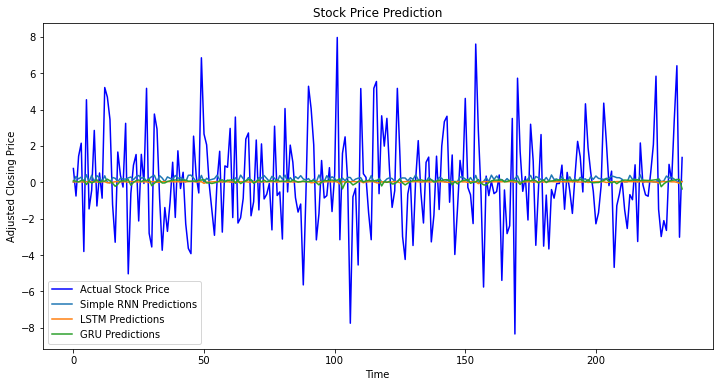

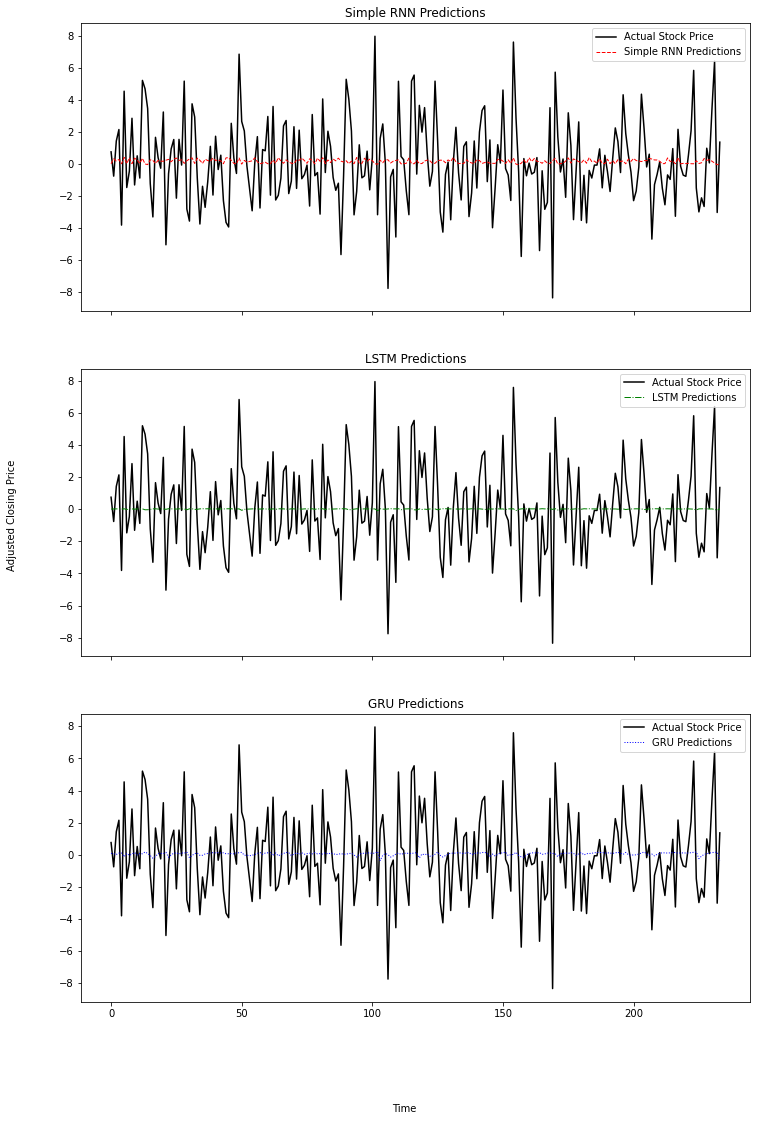

In [74]:
# Load best model
best_simple_rnn = load_model('best_simplernn_combank.keras')
best_lstm = load_model('best_lstm_combank.keras')
best_gru = load_model('best_gru_combank.keras')  
# Predicted values for each model
predicted_simple_rnn = best_simple_rnn.predict(X_test)
predicted_lstm = best_lstm.predict(X_test)
predicted_gru = best_gru.predict(X_test)  
# Test loss for each model
test_loss_simple_rnn = best_simple_rnn.evaluate(X_test, y_test)
test_loss_lstm = best_lstm.evaluate(X_test, y_test)
test_loss_gru = best_gru.evaluate(X_test, y_test)
# Plot compare the predicted values with actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Stock Price', color='blue')  
plt.plot(predicted_simple_rnn, label='Simple RNN Predictions')
plt.plot(predicted_lstm, label='LSTM Predictions')
plt.plot(predicted_gru, label='GRU Predictions')  
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Adjusted Closing Price')
plt.legend()
plt.show()

# Create subplots with shared x-axis
fig, axs = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

# Actual vs Simple RNN
axs[0].plot(y_test, color='black', label='Actual Stock Price')  
axs[0].plot(predicted_simple_rnn, 'r--', label='Simple RNN Predictions', linewidth=1)
axs[0].set_title('Simple RNN Predictions')
axs[0].legend()

# Actual vs LSTM
axs[1].plot(y_test, color='black', label='Actual Stock Price')  
axs[1].plot(predicted_lstm, 'g-.', label='LSTM Predictions', linewidth=1)
axs[1].set_title('LSTM Predictions')
axs[1].legend()

# Actual vs GRU
axs[2].plot(y_test, color='black', label='Actual Stock Price')  
axs[2].plot(predicted_gru, 'b:', label='GRU Predictions', linewidth=1)  
axs[2].set_title('GRU Predictions')
axs[2].legend()

# Set common labels
fig.text(0.5, 0.04, 'Time', ha='center')
fig.text(0.04, 0.5, 'Adjusted Closing Price', va='center', rotation='vertical')

plt.show()

Obtain the correlation between predicted values and actuual values for each best model.

In [75]:
# Calculate the correlation coefficient
print("correlation between RNN predicted values and actual data: ",np.corrcoef(predicted_simple_rnn.flatten(), y_test.flatten())[0, 1])
print("correlation between LSTM predicted values and actual data: ",np.corrcoef(predicted_lstm.flatten(), y_test.flatten())[0, 1])
print("correlation between GRU predicted values and actual data: ",np.corrcoef(predicted_gru.flatten(), y_test.flatten())[0, 1])

correlation between RNN predicted values and actual data:  -0.06172852951650077
correlation between LSTM predicted values and actual data:  -0.025788225458145592
correlation between GRU predicted values and actual data:  0.08682181086323196


## Vipshop stock data

The data set is avaliable at: https://finance.yahoo.com/quote/VIPS/history

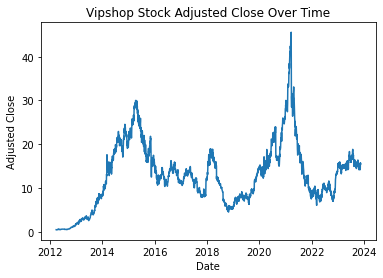

In [62]:
# Reading the data from CSV file
VipStock = pd.read_csv("VIPS.csv")

# Selecting the Adjusted Close column
VipStock_AdjClose = VipStock['Adj Close']

# Converting the column to a time series
VipStock_AdjClose_ts = pd.Series(VipStock_AdjClose.values, index=pd.to_datetime(VipStock['Date']))

# Plotting the time series
plt.plot(VipStock_AdjClose_ts)
plt.title('Vipshop Stock Adjusted Close Over Time')
plt.xlabel('Date')
plt.ylabel('Adjusted Close')
plt.show()

The plot shows the time series is non-stationary. So the data is tranformed to a stationary series

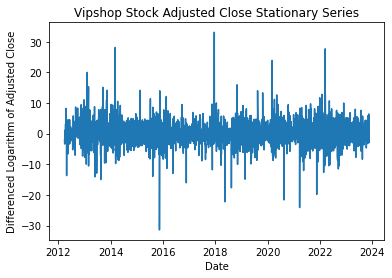

In [63]:
# Calculating the logarithm of the Adjusted Close prices
log_VipStock_AdjClose = np.log(VipStock_AdjClose_ts)

# Compute the difference to obtain a stationary series
VipStock_AdjClose_stationary = log_VipStock_AdjClose.diff() * 100

# Drop NaN values that result from differencing
VipStock_AdjClose_stationary = VipStock_AdjClose_stationary.dropna()

# Plotting the stationary series
plt.plot(VipStock_AdjClose_stationary)
plt.title('Vipshop Stock Adjusted Close Stationary Series')
plt.xlabel('Date')
plt.ylabel('Differenced Logarithm of Adjusted Close')
plt.show()

Acf and Pacf are obtained to check the stationarity of the data

C:\Users\ACER\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


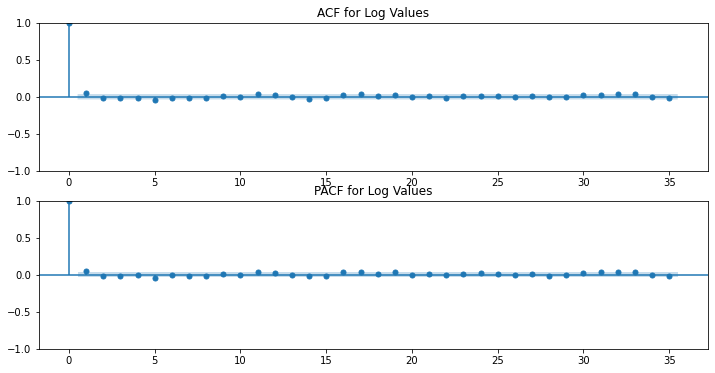

In [64]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(VipStock_AdjClose_stationary, ax=plt.gca(), title='ACF for Log Values')
plt.subplot(212)
plot_pacf(VipStock_AdjClose_stationary, ax=plt.gca(), title='PACF for Log Values')
plt.show()

QQ plot is obtained to check the distribution of the data.

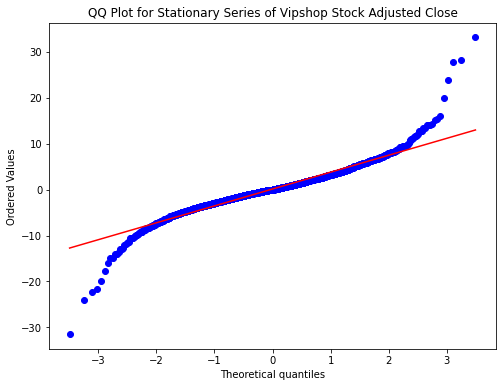

In [65]:
import scipy.stats as stats
# QQ plot for the stationary series
plt.figure(figsize=(8, 6))
stats.probplot(VipStock_AdjClose_stationary, dist="norm", plot=plt)
plt.title('QQ Plot for Stationary Series of Vipshop Stock Adjusted Close')
plt.show()

Reshape the data for the future use.

In [66]:
VipStock_AdjClose_stationary = VipStock_AdjClose_stationary.values
VipStock_AdjClose_stationary = VipStock_AdjClose_stationary.reshape(-1, 1)

Create the traning, validation and testing data

In [67]:
# Define the size for each set
train_size = int(len(VipStock_AdjClose_stationary) * 0.7)
validation_size = int(len(VipStock_AdjClose_stationary) * 0.2)
test_size = len(VipStock_AdjClose_stationary) - train_size - validation_size

# Split the data while maintaining the sequence
train = VipStock_AdjClose_stationary[:train_size]
validation = VipStock_AdjClose_stationary[train_size:train_size+validation_size]
test = VipStock_AdjClose_stationary[train_size+validation_size:]

print(f"Training Set Shape: {train.shape}")
print(f"Validation Set Shape: {validation.shape}")
print(f"Test Set Shape: {test.shape}")

Training Set Shape: (2052, 1)
Validation Set Shape: (586, 1)
Test Set Shape: (294, 1)


Create sequence of data for RNNs architecures.

In [68]:
# Updated Data Preparation Function
def create_sequences(data, time_steps=1):
    Xs, ys = [], []
    for i in range(len(data) - time_steps):
        Xs.append(data[i:(i + time_steps)])
        ys.append(data[i + time_steps])
    return np.array(Xs), np.array(ys)

# Define the time steps for each sequence
time_steps = 60

# Prepare the sequences
X_train, y_train = create_sequences(train, time_steps)
X_val, y_val = create_sequences(validation, time_steps)
X_test, y_test = create_sequences(test, time_steps)

Train the model with set of hyperparameters to obtain the best parameter for each model.

In [69]:
# Initialize best models and losses
best_models = {'SimpleRNN': None, 'LSTM': None, 'GRU': None}
lowest_val_losses = {'SimpleRNN': float('inf'), 'LSTM': float('inf'), 'GRU': float('inf')}
best_params = {'SimpleRNN': {}, 'LSTM': {}, 'GRU': {}}

# Loop for each model type
for model_type in ['SimpleRNN', 'LSTM', 'GRU']:
    for unit in units:
        for dropout_rate in dropout_rates:
            for lr in learning_rates:
                for reg_name, reg_function in regularizations:
                    # Build model based on type
                    if model_type == 'SimpleRNN':
                        model = build_simple_rnn((60, 1), unit, dropout_rate, lr, reg_function)
                    elif model_type == 'LSTM':
                        model = build_lstm((60, 1), unit, dropout_rate, lr, reg_function)
                    elif model_type == 'GRU':
                        model = build_gru_model((60, 1), unit, dropout_rate, lr, reg_function)

                    # Train and evaluate
                    history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[early_stopping])
                    val_loss = min(history.history['val_loss'])

                    # Update best model and parameters if improvement found
                    if val_loss < lowest_val_losses[model_type]:
                        best_models[model_type] = model
                        lowest_val_losses[model_type] = val_loss
                        best_params[model_type] = {
                            'unit': unit,
                            'dropout_rate': dropout_rate,
                            'learning_rate': lr,
                            'regularization': reg_name
                        }

Epoch 1/20
63/63 [==============================] - 2s 10ms/step - loss: 15.4011 - val_loss: 19.0339
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 14.8339 - val_loss: 19.2459
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 14.8101 - val_loss: 19.3025
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 14.7572 - val_loss: 19.0824
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 14.2766 - val_loss: 19.1510
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 14.3284 - val_loss: 19.1399
Epoch 1/20
63/63 [==============================] - 2s 11ms/step - loss: 15.6076 - val_loss: 18.9073
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 14.7130 - val_loss: 18.9833
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 14.6766 - val_loss: 19.0118
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 14.6217 - val_loss: 19.015

63/63 [==============================] - 1s 8ms/step - loss: 14.2980 - val_loss: 19.3857
Epoch 5/20
63/63 [==============================] - 1s 8ms/step - loss: 14.3304 - val_loss: 19.0515
Epoch 6/20
63/63 [==============================] - 1s 8ms/step - loss: 14.2232 - val_loss: 19.4001
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 14.1081 - val_loss: 19.1986
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 13.5142 - val_loss: 19.3825
Epoch 1/20
63/63 [==============================] - 2s 11ms/step - loss: 15.3949 - val_loss: 18.8450
Epoch 2/20
63/63 [==============================] - 1s 8ms/step - loss: 15.0053 - val_loss: 19.2043
Epoch 3/20
63/63 [==============================] - 1s 8ms/step - loss: 14.6684 - val_loss: 19.1301
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 14.5275 - val_loss: 19.1426
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 14.3297 - val_loss: 19.1287
Epoch 6/20

Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 14.6856 - val_loss: 18.8574
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 14.7059 - val_loss: 18.9859
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 14.5165 - val_loss: 19.0449
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 14.6714 - val_loss: 19.1720
Epoch 6/20
63/63 [==============================] - 0s 7ms/step - loss: 14.1903 - val_loss: 19.1742
Epoch 1/20
63/63 [==============================] - 1s 10ms/step - loss: 15.4158 - val_loss: 19.1338
Epoch 2/20
63/63 [==============================] - 0s 7ms/step - loss: 14.6579 - val_loss: 18.9265
Epoch 3/20
63/63 [==============================] - 0s 7ms/step - loss: 14.7457 - val_loss: 19.4104
Epoch 4/20
63/63 [==============================] - 0s 7ms/step - loss: 14.6734 - val_loss: 19.1512
Epoch 5/20
63/63 [==============================] - 0s 7ms/step - loss: 14.6261 - val_loss: 18.9717

63/63 [==============================] - 1s 8ms/step - loss: 14.7215 - val_loss: 18.8416
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 14.6575 - val_loss: 18.9079
Epoch 8/20
63/63 [==============================] - 1s 8ms/step - loss: 14.7880 - val_loss: 18.8113
Epoch 9/20
63/63 [==============================] - 1s 8ms/step - loss: 14.6611 - val_loss: 18.9807
Epoch 10/20
63/63 [==============================] - 1s 9ms/step - loss: 14.5228 - val_loss: 18.8482
Epoch 11/20
63/63 [==============================] - 1s 8ms/step - loss: 14.4620 - val_loss: 18.8808
Epoch 12/20
63/63 [==============================] - 1s 9ms/step - loss: 14.4863 - val_loss: 19.0062
Epoch 13/20
63/63 [==============================] - 1s 10ms/step - loss: 14.5916 - val_loss: 18.9462
Epoch 1/20
63/63 [==============================] - 2s 13ms/step - loss: 15.7808 - val_loss: 19.1003
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 14.6467 - val_loss: 19.4467
Epoch

63/63 [==============================] - 1s 15ms/step - loss: 14.3153 - val_loss: 18.8342
Epoch 1/20
63/63 [==============================] - 3s 20ms/step - loss: 14.5597 - val_loss: 18.8746
Epoch 2/20
63/63 [==============================] - 1s 14ms/step - loss: 14.4234 - val_loss: 18.8916
Epoch 3/20
63/63 [==============================] - 1s 14ms/step - loss: 14.3788 - val_loss: 19.0946
Epoch 4/20
63/63 [==============================] - 1s 15ms/step - loss: 14.3980 - val_loss: 18.8546
Epoch 5/20
63/63 [==============================] - 1s 14ms/step - loss: 14.3606 - val_loss: 18.8585
Epoch 6/20
63/63 [==============================] - 1s 14ms/step - loss: 14.3852 - val_loss: 18.7881
Epoch 7/20
63/63 [==============================] - 1s 14ms/step - loss: 14.3814 - val_loss: 18.8474
Epoch 8/20
63/63 [==============================] - 1s 14ms/step - loss: 14.4270 - val_loss: 19.2830
Epoch 9/20
63/63 [==============================] - 1s 14ms/step - loss: 14.7722 - val_loss: 19.3561
E

63/63 [==============================] - 2s 25ms/step - loss: 14.2246 - val_loss: 18.9553
Epoch 1/20
63/63 [==============================] - 4s 30ms/step - loss: 14.5452 - val_loss: 18.9503
Epoch 2/20
63/63 [==============================] - 2s 26ms/step - loss: 14.4247 - val_loss: 18.8471
Epoch 3/20
63/63 [==============================] - 2s 25ms/step - loss: 14.4310 - val_loss: 18.8716
Epoch 4/20
63/63 [==============================] - 2s 26ms/step - loss: 14.4064 - val_loss: 18.8595
Epoch 5/20
63/63 [==============================] - 2s 28ms/step - loss: 14.4063 - val_loss: 18.8301
Epoch 6/20
63/63 [==============================] - 2s 26ms/step - loss: 14.4797 - val_loss: 18.8982
Epoch 7/20
63/63 [==============================] - 2s 27ms/step - loss: 14.4563 - val_loss: 18.8608
Epoch 8/20
63/63 [==============================] - 2s 27ms/step - loss: 14.3973 - val_loss: 18.8840
Epoch 9/20
63/63 [==============================] - 1s 23ms/step - loss: 14.4182 - val_loss: 18.8583
E

Monitor the losses during the training process of each best model by using Tensorboard.

In [70]:
# Print the best parameters for each model
print("Best SimpleRNN parameters:", best_params['SimpleRNN'])
print("Best LSTM parameters:", best_params['LSTM'])
print("Best GRU parameters:", best_params['GRU'])

# Function to rebuild and retrain the best model with TensorBoard
def retrain_best_model(model_type, best_params):
    best_log_dir = f"logs/Vipshop/{model_type}/best_model"
    best_tensorboard_callback = TensorBoard(log_dir=best_log_dir, histogram_freq=1, write_graph=True, write_images=True)

    # Rebuild the best model with the best hyperparameters
    best_unit = best_params['unit']
    best_dropout_rate = best_params['dropout_rate']
    best_lr = best_params['learning_rate']
    best_reg_function = {'l1': l1(0.01), 'l2': l2(0.01)}[best_params['regularization']]

    if model_type == 'SimpleRNN':
        best_model = build_simple_rnn((60, 1), best_unit, best_dropout_rate, best_lr, best_reg_function)
    elif model_type == 'LSTM':
        best_model = build_lstm((60, 1), best_unit, best_dropout_rate, best_lr, best_reg_function)
    elif model_type == 'GRU':
        best_model = build_gru_model((60, 1), best_unit, best_dropout_rate, best_lr, best_reg_function)

    # Re-train the best model
    best_model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[best_tensorboard_callback, early_stopping])

    # Save the best model
    best_model.save(f'best_{model_type.lower()}_vipshop.keras')

# Retrain and save the best models for SimpleRNN, LSTM, and GRU
for model_type in ['SimpleRNN', 'LSTM', 'GRU']:
    if best_models[model_type] is not None:
        retrain_best_model(model_type, best_params[model_type])

Best SimpleRNN parameters: {'unit': 50, 'dropout_rate': 0.3, 'learning_rate': 0.001, 'regularization': 'l2'}
Best LSTM parameters: {'unit': 50, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'regularization': 'l2'}
Best GRU parameters: {'unit': 100, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'regularization': 'l2'}
Epoch 1/20
63/63 [==============================] - 2s 11ms/step - loss: 15.3314 - val_loss: 18.9142
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 15.1125 - val_loss: 18.9242
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 15.0166 - val_loss: 18.8860
Epoch 4/20
63/63 [==============================] - 1s 8ms/step - loss: 14.6018 - val_loss: 18.9339
Epoch 5/20
63/63 [==============================] - 1s 9ms/step - loss: 14.8488 - val_loss: 18.9546
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 14.4231 - val_loss: 18.9373
Epoch 7/20
63/63 [==============================] - 1s 8ms/step - loss: 14.5457 - v

Load the Tensorboard.

In [71]:
%reload_ext tensorboard
%tensorboard --logdir logs --port 6013

Reusing TensorBoard on port 6013 (pid 14740), started 3:23:56 ago. (Use '!kill 14740' to kill it.)

Obtain the predicted values of each model with loss and compare with the actual data.

8/8 [==============================] - 0s 7ms/step - loss: 7.0704


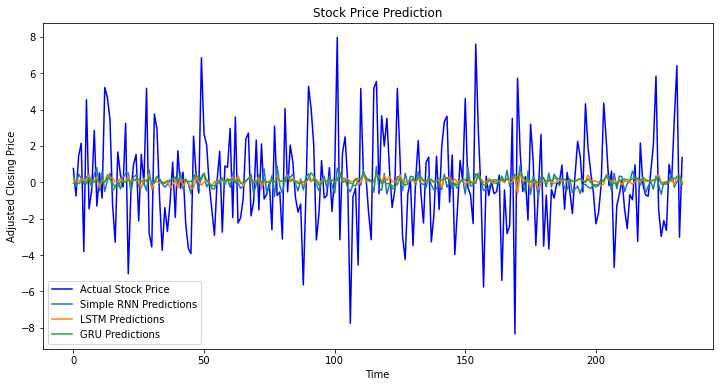

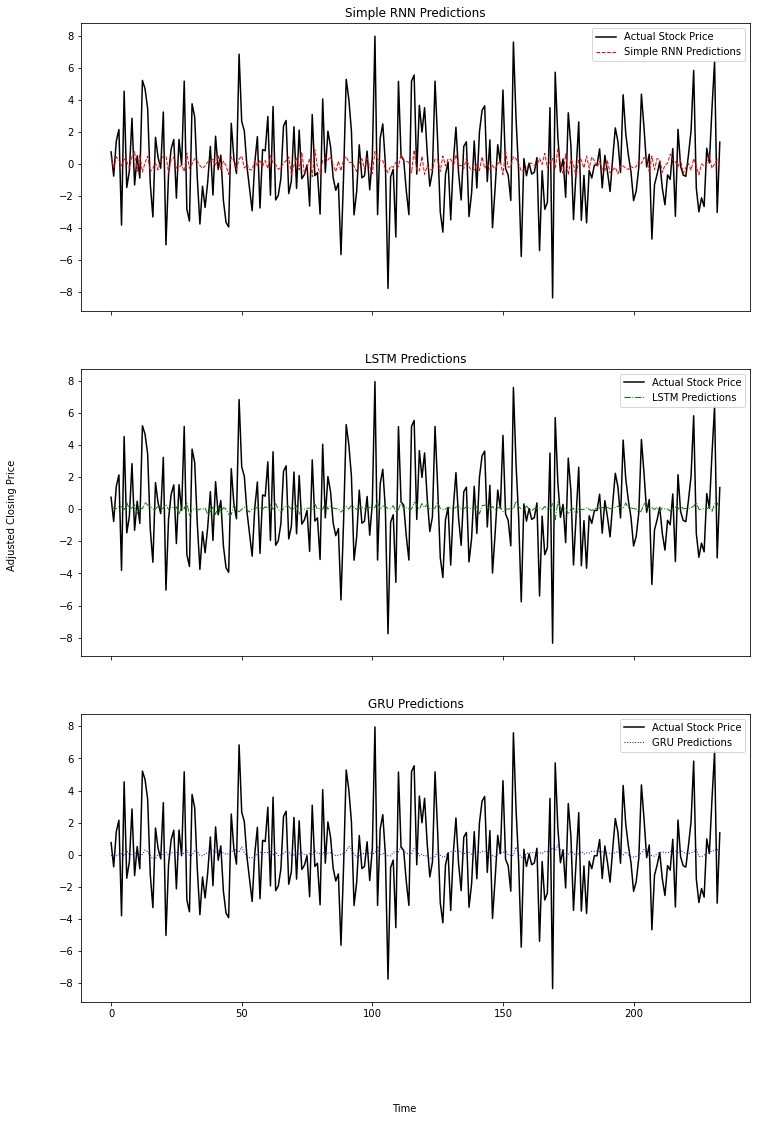

In [72]:
# Load best model
best_simple_rnn = load_model('best_simplernn_vipshop.keras')
best_lstm = load_model('best_lstm_vipshop.keras')
best_gru = load_model('best_gru_vipshop.keras')  # Changed from best_attention to best_gru
# Predicted values for each model
predicted_simple_rnn = best_simple_rnn.predict(X_test)
predicted_lstm = best_lstm.predict(X_test)
predicted_gru = best_gru.predict(X_test)  # Changed from predicted_attention to predicted_gru
# Test loss for each model
test_loss_simple_rnn = best_simple_rnn.evaluate(X_test, y_test)
test_loss_lstm = best_lstm.evaluate(X_test, y_test)
test_loss_gru = best_gru.evaluate(X_test, y_test)  # Changed from test_loss_attention to test_loss_gru
# Plot compare the predicted values with actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Stock Price', color='blue')  # Changed line color to blue
plt.plot(predicted_simple_rnn, label='Simple RNN Predictions')
plt.plot(predicted_lstm, label='LSTM Predictions')
plt.plot(predicted_gru, label='GRU Predictions')  # Changed from Attention to GRU
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Adjusted Closing Price')
plt.legend()
plt.show()

# Create subplots with shared x-axis
fig, axs = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

# Actual vs Simple RNN
axs[0].plot(y_test, color='black', label='Actual Stock Price')  # Changed line color to blue
axs[0].plot(predicted_simple_rnn, 'r--', label='Simple RNN Predictions', linewidth=1)
axs[0].set_title('Simple RNN Predictions')
axs[0].legend()

# Actual vs LSTM
axs[1].plot(y_test, color='black', label='Actual Stock Price')  # Changed line color to blue
axs[1].plot(predicted_lstm, 'g-.', label='LSTM Predictions', linewidth=1)
axs[1].set_title('LSTM Predictions')
axs[1].legend()

# Actual vs GRU
axs[2].plot(y_test, color='black', label='Actual Stock Price')  # Changed line color to blue
axs[2].plot(predicted_gru, 'b:', label='GRU Predictions', linewidth=1)  # Changed from Attention to GRU
axs[2].set_title('GRU Predictions')
axs[2].legend()

# Set common labels
fig.text(0.5, 0.04, 'Time', ha='center')
fig.text(0.04, 0.5, 'Adjusted Closing Price', va='center', rotation='vertical')

plt.show()

Obtain the correlation between predicted values and actuual values for each best model.

In [73]:
# Calculate the correlation coefficient
print("correlation between RNN predicted values and actual data: ",np.corrcoef(predicted_simple_rnn.flatten(), y_test.flatten())[0, 1])
print("correlation between LSTM predicted values and actual data: ",np.corrcoef(predicted_lstm.flatten(), y_test.flatten())[0, 1])
print("correlation between GRU predicted values and actual data: ",np.corrcoef(predicted_gru.flatten(), y_test.flatten())[0, 1])

correlation between RNN predicted values and actual data:  0.08500471010734455
correlation between LSTM predicted values and actual data:  -0.0446164527788625
correlation between GRU predicted values and actual data:  0.11642552894844242
